# Tutorial task - Embeddings

Authors: 
- Mikołaj Gałkowski
- Julia Przybytniowska

### Preprocessing steps

1. Removing non-alphanumeric characters.
2. Removing stopwords.
3. Lemmatization
4. Stemming.

We will try out their different combinations when training our models.

In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


def clean_text(text):
    text = re.sub(r"[^A-Za-z\s]", "", text.lower())
    return text


def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])


def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])


def preprocess_text(text, preprocessing_steps):
    text = clean_text(text)
    if "stopwords" in preprocessing_steps:
        text = remove_stopwords(text)
    if "lemmatization" in preprocessing_steps:
        text = lemmatize_text(text)
    if "stemming" in preprocessing_steps:
        text = stem_text(text)
    return text

In [3]:
import warnings

from datasets import load_dataset

warnings.filterwarnings("ignore")

imdb = load_dataset("stanfordnlp/imdb")
del imdb["unsupervised"]  # stay only with train / test

## Word2Vec, FastText and Glove

All three embedding method are pretrained ones. Word2Vec and FastText return embeddings of 300 length and GloVe of 200.

In [6]:
import gensim

print("Loading word2vec")
word2vec_embeddings = gensim.downloader.load("word2vec-google-news-300")

print("Loading fasttext")
fasttext_embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

print("Loading glove")
glove_embeddings = gensim.downloader.load("glove-twitter-200")

Loading word2vec
Loading fasttext
Loading glove


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score


# function to get the average word vector for a sentence
def get_average_word_vector(sentence, model, vector_size=300):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)


train = imdb["train"].to_pandas()
test = imdb["test"].to_pandas()

X_train = train["text"]
y_train = train["label"]
X_test = test["text"]
y_test = test["label"]

Below preprocessing combinations are proposed and different classification models such as:
- Logisitic Regression,
- Naive Bayes,
- Random Forest Classifier,
- XGBoost Classifier.

In [16]:
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

preprocessing_options = [
    None,  # No preprocessing
    ["stopwords"],  # Remove stopwords
    ["lemmatization"],  # Lemmatization
    ["stemming"],  # Stemming
    ["stopwords", "lemmatization"],  # Stopwords + Lemmatization
    ["stopwords", "stemming"],  # Stopwords + Stemming
]

model_classes = [
    LogisticRegression,
    GaussianNB,
    RandomForestClassifier,
    xgb.XGBClassifier,
]

results_list = []

for preprocessing in tqdm(preprocessing_options, desc="Preprocessing Type"):
    X_train_processed = X_train.apply(
        lambda x: preprocess_text(x, preprocessing) if preprocessing else x
    )
    X_test_processed = X_test.apply(
        lambda x: preprocess_text(x, preprocessing) if preprocessing else x
    )

    X_train_word2vec = np.array(
        [
            get_average_word_vector(text, word2vec_embeddings, vector_size=300)
            for text in X_train_processed
        ]
    )
    X_test_word2vec = np.array(
        [
            get_average_word_vector(text, word2vec_embeddings, vector_size=300)
            for text in X_test_processed
        ]
    )

    X_train_fasttext = np.array(
        [
            get_average_word_vector(text, fasttext_embeddings, vector_size=300)
            for text in X_train_processed
        ]
    )
    X_test_fasttext = np.array(
        [
            get_average_word_vector(text, fasttext_embeddings, vector_size=300)
            for text in X_test_processed
        ]
    )

    X_train_glove = np.array(
        [
            get_average_word_vector(text, glove_embeddings, vector_size=200)
            for text in X_train_processed
        ]
    )
    X_test_glove = np.array(
        [
            get_average_word_vector(text, glove_embeddings, vector_size=200)
            for text in X_test_processed
        ]
    )

    embedding_data = [
        ("word2vec", X_train_word2vec, X_test_word2vec),
        ("fasttext", X_train_fasttext, X_test_fasttext),
        ("glove", X_train_glove, X_test_glove),
    ]

    for model_class in tqdm(model_classes, desc="Model Type", leave=False):
        for name, X__train, X__test in embedding_data:
            params = {"max_iter": 1000} if model_class == LogisticRegression else {}
            model = model_class(**params) if params else model_class()

            model.fit(X__train, y_train)

            y_pred = model.predict(X__test)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            results_list.append(
                {
                    "Model": model_class.__name__,
                    "Embedding": name,
                    "Preprocessing": preprocessing if preprocessing else "None",
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1": f1,
                }
            )

results = pd.concat([pd.DataFrame([res]) for res in results_list], ignore_index=True)
results

Preprocessing Type:   0%|          | 0/6 [00:00<?, ?it/s]

Model Type:   0%|          | 0/4 [00:00<?, ?it/s]

Model Type:   0%|          | 0/4 [00:00<?, ?it/s]

Model Type:   0%|          | 0/4 [00:00<?, ?it/s]

Model Type:   0%|          | 0/4 [00:00<?, ?it/s]

Model Type:   0%|          | 0/4 [00:00<?, ?it/s]

Model Type:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Embedding,Preprocessing,Accuracy,Precision,Recall,F1
0,LogisticRegression,word2vec,None,0.82768,0.833008,0.81968,0.826290
1,LogisticRegression,fasttext,None,0.77892,0.786413,0.76584,0.775990
2,LogisticRegression,glove,None,0.81252,0.817421,0.80480,0.811061
3,GaussianNB,word2vec,None,0.69820,0.729038,0.63088,0.676416
4,GaussianNB,fasttext,None,0.68188,0.712695,0.60944,0.657036
...,...,...,...,...,...,...,...
67,RandomForestClassifier,fasttext,"[stopwords, stemming]",0.75668,0.760494,0.74936,0.754886
68,RandomForestClassifier,glove,"[stopwords, stemming]",0.74148,0.739165,0.74632,0.742725
69,XGBClassifier,word2vec,"[stopwords, stemming]",0.78088,0.779850,0.78272,0.781282
70,XGBClassifier,fasttext,"[stopwords, stemming]",0.78616,0.789870,0.77976,0.784783


In [17]:
# results.to_csv('results_not_transformers.csv', index=False)
# results = pd.read_csv('results_not_transformers.csv')

# Fine-tuning Distil Bert 

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(
    device
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)


tokenized_imdb = imdb.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [21]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(
        predictions=predictions, references=labels, average="binary"
    )
    recall = recall_metric.compute(
        predictions=predictions, references=labels, average="binary"
    )
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

In [25]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.207738,0.924640,0.926825,0.922080,0.924447
2,0.136400,0.219272,0.929160,0.933145,0.924560,0.928833
3,0.090700,0.244043,0.929840,0.925146,0.935360,0.930225


No files have been modified since last commit. Skipping to prevent empty commit.


TrainOutput(global_step=1173, training_loss=0.10757970931889761, metrics={'train_runtime': 1098.4496, 'train_samples_per_second': 68.278, 'train_steps_per_second': 1.068, 'total_flos': 9935003154122400.0, 'train_loss': 0.10757970931889761, 'epoch': 3.0})

In [26]:
results = trainer.evaluate()
print(f"Test results: {results}")

Test results: {'eval_loss': 0.20773789286613464, 'eval_accuracy': 0.92464, 'eval_precision': 0.9268253457703441, 'eval_recall': 0.92208, 'eval_f1': 0.924446583253128, 'eval_runtime': 92.962, 'eval_samples_per_second': 268.927, 'eval_steps_per_second': 4.206, 'epoch': 3.0}


In [30]:
predictions = trainer.predict(tokenized_imdb["test"])

preds = torch.argmax(torch.tensor(predictions.predictions), dim=1)

In [38]:
# Calculate additional metrics manually and add to a DataFrame
accuracy = accuracy_metric.compute(
    predictions=preds.numpy(), references=tokenized_imdb["test"]["label"]
)
precision = precision_metric.compute(
    predictions=preds.numpy(),
    references=tokenized_imdb["test"]["label"],
    average="binary",
)
recall = recall_metric.compute(
    predictions=preds.numpy(),
    references=tokenized_imdb["test"]["label"],
    average="binary",
)
f1 = f1_metric.compute(
    predictions=preds.numpy(),
    references=tokenized_imdb["test"]["label"],
    average="binary",
)

df_results = pd.DataFrame(
    [
        {
            "Model": "distilbert-base-uncased",
            "Embedding": "-",
            "Preprocessing": "-",
            "Accuracy": accuracy["accuracy"],
            "Precision": precision["precision"],
            "Recall": recall["recall"],
            "F1": f1["f1"],
        }
    ]
)

df_results.to_csv("distilbert.csv", index=False)
# df_results = pd.read_csv("distilbert.csv")

## Using finetuned model from HuggingFace 

Not fine-tuning, just inference on out-of-the-box model imported from HF hub.

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

### We checked distribution of the length of inputs in the test set to find out the optimal `max_length` parameter.

In [84]:
tokenized_lengths = [
    len(tokenizer(x)["input_ids"]) for x in tokenized_imdb["test"]["text"]
]

lengths_df = pd.DataFrame(tokenized_lengths, columns=["length"])

lengths_df.describe()

,length
count,25000.000000
mean,297.807480
std,220.395691
min,10.000000
25%,161.000000
50%,223.000000
75%,361.250000
max,3090.000000


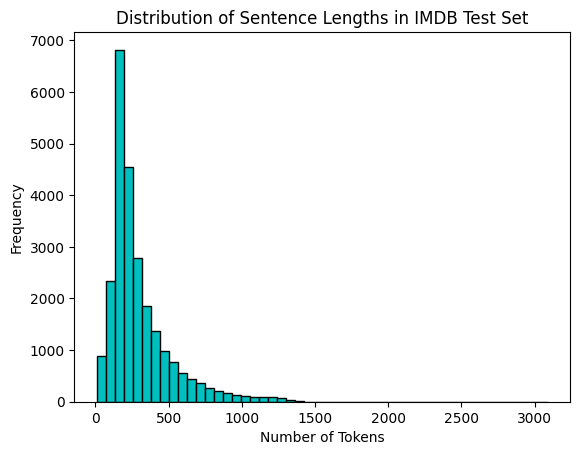

In [85]:
import matplotlib.pyplot as plt

plt.hist(lengths_df["length"], bins=50, color="c", edgecolor="black")
plt.title("Distribution of Sentence Lengths in IMDB Test Set")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

### We decided to stick with the `1024 max_length` as there wasn't any specified for this model in the config.

In [97]:
tokenizer = AutoTokenizer.from_pretrained("dfurman/deberta-v3-base-imdb")
model = AutoModelForSequenceClassification.from_pretrained(
    "dfurman/deberta-v3-base-imdb"
)


def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=1024, truncation=True, padding=True)


tokenized_imdb = imdb.map(tokenize_function, batched=True)

test_loader = DataLoader(tokenized_imdb["test"].with_format("torch"), batch_size=64)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [98]:
model.eval()

all_preds = []
all_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

  0%|          | 0/391 [00:00<?, ?it/s]

In [99]:
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

accuracy = accuracy_metric.compute(predictions=all_preds, references=all_labels)
precision = precision_metric.compute(
    predictions=all_preds, references=all_labels, average="binary"
)
recall = recall_metric.compute(
    predictions=all_preds, references=all_labels, average="binary"
)
f1 = f1_metric.compute(predictions=all_preds, references=all_labels, average="binary")

df_results = pd.DataFrame(
    [
        {
            "Model": "deberta-v3-base-imdb",
            "Embedding": "-",
            "Preprocessing": "-",
            "Accuracy": accuracy["accuracy"],
            "Precision": precision["precision"],
            "Recall": recall["recall"],
            "F1": f1["f1"],
        }
    ]
)

df_results.to_csv("deberta_results.csv", index=False)
df_results

,Model,Embedding,Preprocessing,Accuracy,Precision,Recall,F1
0,deberta-v3-base-imdb,-,-,0.95404,0.943087,0.9664,0.954601


In [4]:
import os

res = pd.DataFrame(
    columns=[
        "Model",
        "Embedding",
        "Preprocessing",
        "Accuracy",
        "Precision",
        "Recall",
        "F1",
    ]
)
for file in os.listdir("./"):
    if file.endswith(".csv"):
        res = pd.concat([res, pd.read_csv(file)])
res

/tmp/ipykernel_515775/3323215690.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, pd.read_csv('./wyniki/' + file)])


,Model,Embedding,Preprocessing,Accuracy,Precision,Recall,F1
0,LogisticRegression,word2vec,NaN,0.82768,0.833008,0.81968,0.826290
1,LogisticRegression,fasttext,NaN,0.77892,0.786413,0.76584,0.775990
2,LogisticRegression,glove,NaN,0.81252,0.817421,0.80480,0.811061
3,GaussianNB,word2vec,NaN,0.69820,0.729038,0.63088,0.676416
4,GaussianNB,fasttext,NaN,0.68188,0.712695,0.60944,0.657036
...,...,...,...,...,...,...,...
69,XGBClassifier,word2vec,"['stopwords', 'stemming']",0.78088,0.779850,0.78272,0.781282
70,XGBClassifier,fasttext,"['stopwords', 'stemming']",0.78616,0.789870,0.77976,0.784783
71,XGBClassifier,glove,"['stopwords', 'stemming']",0.76688,0.771220,0.75888,0.765000
0,deberta-v3-base-imdb,-,-,0.95404,0.943087,0.96640,0.954601


# Top 5 Results based on each metric 

## Accuracy

In [5]:
res.sort_values("Accuracy", ascending=False).head(5)

,Model,Embedding,Preprocessing,Accuracy,Precision,Recall,F1
0,deberta-v3-base-imdb,-,-,0.95404,0.943087,0.96640,0.954601
0,distilbert-base-uncased,-,-,0.92464,0.926825,0.92208,0.924447
12,LogisticRegression,word2vec,['stopwords'],0.85124,0.853360,0.84824,0.850792
48,LogisticRegression,word2vec,"['stopwords', 'lemmatization']",0.84840,0.851153,0.84448,0.847803
24,LogisticRegression,word2vec,['lemmatization'],0.84464,0.850814,0.83584,0.843261


## Precision

In [6]:
res.sort_values("Precision", ascending=False).head(5)

,Model,Embedding,Preprocessing,Accuracy,Precision,Recall,F1
0,deberta-v3-base-imdb,-,-,0.95404,0.943087,0.96640,0.954601
0,distilbert-base-uncased,-,-,0.92464,0.926825,0.92208,0.924447
12,LogisticRegression,word2vec,['stopwords'],0.85124,0.853360,0.84824,0.850792
48,LogisticRegression,word2vec,"['stopwords', 'lemmatization']",0.84840,0.851153,0.84448,0.847803
24,LogisticRegression,word2vec,['lemmatization'],0.84464,0.850814,0.83584,0.843261


## Recall

In [7]:
res.sort_values("Recall", ascending=False).head(5)

,Model,Embedding,Preprocessing,Accuracy,Precision,Recall,F1
0,deberta-v3-base-imdb,-,-,0.95404,0.943087,0.96640,0.954601
0,distilbert-base-uncased,-,-,0.92464,0.926825,0.92208,0.924447
12,LogisticRegression,word2vec,['stopwords'],0.85124,0.853360,0.84824,0.850792
48,LogisticRegression,word2vec,"['stopwords', 'lemmatization']",0.84840,0.851153,0.84448,0.847803
24,LogisticRegression,word2vec,['lemmatization'],0.84464,0.850814,0.83584,0.843261


## F1 score

In [8]:
res.sort_values("F1", ascending=False).head(5)

,Model,Embedding,Preprocessing,Accuracy,Precision,Recall,F1
0,deberta-v3-base-imdb,-,-,0.95404,0.943087,0.96640,0.954601
0,distilbert-base-uncased,-,-,0.92464,0.926825,0.92208,0.924447
12,LogisticRegression,word2vec,['stopwords'],0.85124,0.853360,0.84824,0.850792
48,LogisticRegression,word2vec,"['stopwords', 'lemmatization']",0.84840,0.851153,0.84448,0.847803
24,LogisticRegression,word2vec,['lemmatization'],0.84464,0.850814,0.83584,0.843261


### Saving final table

In [9]:
res.to_csv("Galkowski_Przybytniowska_results.csv", index=False)

**Disclaimer**: Some parts of the code have been generated using Copilot AI Assistant.